In [1]:
import os
import sys
sys.path.insert(0, r'..\..')
import paths

import panel as pn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import functions_bondjango as bd
import functions_kinematic as fk
import functions_plotting as fp
import functions_preprocessing as fpr
import functions_misc as fm
import functions_data_handling as fd
import pandas as pd
import numpy as np
import h5py

from scipy.stats import sem
line_width = 5

In [2]:
def load_h5_df(df_path):
    h5_obj = pd.HDFStore(df_path)

    data_dict = {}
    data_dict['traces'] = h5_obj.get("full_traces")
    data_dict['session_params'] = h5_obj.get("params")

    # Add a column to the trial_params data set that will properly index the trials
    trial_params = h5_obj.get("trial_set")
    trial_params['trial_num'] = trial_params.index + 1
    data_dict['trial_params'] = trial_params

    return data_dict

In [3]:
def load_VScreens_datasets(search_string, exclusion=None):

    valid_experiments = []

    data_all = bd.query_database('analyzed_data', search_string)

    for ds in data_all:
        if exclusion is not None:
            if exclusion not in ds['analysis_path']:
                exp = load_h5_df(ds['analysis_path'])
                valid_experiments.append(exp)
        else:
            exp = load_h5_df(ds['analysis_path'])
            valid_experiments.append(exp)

    # load the data
    return valid_experiments

In [4]:
def recalculate_2D_target_mouse_distance(exp_traces):

    temp_target_x = exp_traces['target_x'].copy()
    temp_target_y = exp_traces['target_y'].copy()

    print('target y max:', max(temp_target_y), 'target y min:', min(temp_target_y[temp_target_y != -1]))

    mouse_x = exp_traces['mouse_x'].copy()
    mouse_y = exp_traces['mouse_y'].copy()
    print('mouse y max:', max(mouse_y), 'mouse y min:', min(mouse_y))

    x_diff = [abs(max(mouse_x) - max(temp_target_x)), 
             abs(min(mouse_x) - min(temp_target_x[temp_target_x != -1]))]
    y_diff = [abs(max(mouse_y) - max(temp_target_y)),
              abs(min(mouse_y) - min(temp_target_y[temp_target_y != -1]))]

    print('x offset:', x_diff, 'y offset:', y_diff)

    temp_target_y[(temp_target_y > 0)] -= y_diff[0]
    temp_target_y[(temp_target_y < 0) & (temp_target_y > -1)] += y_diff[1]
    
    print('recalc target y max:', max(temp_target_y), 'recalc target y min:', min(temp_target_y[temp_target_y != -1]), '\n')

    # replace the target y coordinates with the newly calculated ones
    exp_traces['target_y'] = temp_target_y

    mouse_coord = exp_traces.loc[:, ['mouse_x', 'mouse_y']].to_numpy()
    target_coord = exp_traces.loc[:, ['target_x', 'target_y']].to_numpy()
    target_mouse_distance = fk.distance_calculation(target_coord, mouse_coord)

    exp_traces['target_mouse_distance_recalc'] = target_mouse_distance
    exp_traces['target_mouse_x_distance'] = np.abs(temp_target_x - exp_traces['mouse_x'])
    exp_traces['target_mouse_y_distance'] = np.abs(temp_target_y - exp_traces['mouse_y']) 

    return exp_traces   

In [5]:
def recalculate_3D_target_mouse_distance(exp_traces):

    # temp_target_x = exp_traces['target_x'].copy()
    # temp_target_y = exp_traces['target_y'].copy()

    # # print('target y max:', max(temp_target_y), 'target y min:', min(temp_target_y[temp_target_y != -1]))

    # mouse_x = exp_traces['mouse_x'].copy()
    # mouse_y = exp_traces['mouse_y'].copy()
    # # print('mouse y max:', max(mouse_y), 'mouse y min:', min(mouse_y))

    # x_diff = [abs(max(mouse_x) - max(temp_target_x)), 
    #          abs(min(mouse_x) - min(temp_target_x[temp_target_x != -1]))]
    # y_diff = [abs(max(mouse_y) - max(temp_target_y)),
    #           abs(min(mouse_y) - min(temp_target_y[temp_target_y != -1]))]

    # print('x offset:', x_diff, 'y offset:', y_diff)

    # temp_target_y[(temp_target_y > 0)] -= y_diff[0]
    # temp_target_y[(temp_target_y < 0) & (temp_target_y > -1)] += y_diff[1]
    
    # print('recalc target y max:', max(temp_target_y), 'recalc target y min:', min(temp_target_y[temp_target_y != -1]), '\n')

    # # replace the target y coordinates with the newly calculated ones
    # exp_traces['target_y'] = temp_target_y

    mouse_coord = exp_traces.loc[:, ['mouse_x', 'mouse_y']].to_numpy()
    target_coord = exp_traces.loc[:, ['target_x', 'target_y']].to_numpy()
    target_mouse_distance = fk.distance_calculation(target_coord, mouse_coord)

    exp_traces['target_mouse_distance_recalc'] = target_mouse_distance
    # exp_traces['target_mouse_x_distance'] = np.abs(temp_target_x - exp_traces['mouse_x'])
    # exp_traces['target_mouse_y_distance'] = np.abs(temp_target_y - exp_traces['mouse_y']) 

    return exp_traces   

In [6]:
def get_parameter_traces(traces: pd.DataFrame, trials: np.ndarray) -> list:
    parameter_traces = pd.DataFrame()

    for trial in trials:
        trial_trace = traces.loc[traces['trial_num'] == trial].copy()
        parameter_traces = parameter_traces.append(trial_trace)

    grouped_parameter = parameter_traces.groupby(['trial_num']).agg(list)    

    return grouped_parameter


In [7]:
def thres_function(param, thres):
    return param <= thres

In [8]:
def encounter_finder(data_in, key, threshold=0.05, window=1.5, start_dist_cutoff=0.05, avg_speed_cutoff=0.15):
    all_encounters = []
    all_trials = []
    valid_encounters = []
    valid_trials = []
    
    for index, row in data_in.iterrows():

        trial = pd.DataFrame(row).T
        trial = trial.apply(pd.Series.explode)

        # This gets us all encounters within one trial
        trial_encs = fpr.timed_event_finder(trial, key, threshold, thres_function, window=window)

        is_enc = []
        good_enc = []
        trial_traces = []
        valid_traces = []

        if len(trial_encs) == 0:
            valid_encounters.append(good_enc)
            valid_trials.append(valid_traces)
            all_encounters.append(is_enc)
            all_trials.append(trial_traces)
        else:
            enc_id_group = trial_encs.groupby('event_id')
            for e, group in enc_id_group:
                trial_traces.append(trial.copy())
                is_enc.append(group.copy())
                # group.head()
                quarter_idx = len(group)//4
                mid_idx = len(group)//2
                # Qualifications for an encounter as in Procacci (decreasing target_mouse_angle, start >= 5cm away, speed >= 15cm/s)
                # angle_start = fk.circmean_deg(group['target_delta_heading'][:quarter_idx].to_list())
                angle_start = group['target_delta_heading'][quarter_idx]
                angle_enc = group['target_delta_heading'][mid_idx]
                angle_change = angle_enc - angle_start
                avg_speed = np.mean(group['mouse_speed'][:mid_idx])
                start_dist = np.abs(group[key][mid_idx] - group[key][0])

                if (start_dist >= start_dist_cutoff) and (avg_speed >= avg_speed_cutoff):#  and (angle_change <= 0):
                    # This is a good encounter
                    good_enc.append(group.copy())
                    valid_traces.append(trial)
                else:
                    # This does not meet one or more of the criteria, so we remove it.
                    pass
            
            valid_encounters.append(good_enc)
            valid_trials.append(valid_traces)
            all_encounters.append(is_enc)
            all_trials.append(trial_traces)

    return all_encounters, all_trials, valid_encounters, valid_trials

In [10]:
# define the name to be used for the saved figures
dimensionality = '2D'
save_name = 'VScreen_' + dimensionality

search_string = 'result:test, lighting:normal, rig:VScreen, analysis_type:preprocessing, notes:{}'.format(dimensionality)
data = load_VScreens_datasets(search_string)

In [27]:
exp_manipulation_params = ['color_target', 'scale', 'speed']
trial_encounters = pd.DataFrame(columns=['experiment', 'trial_num', 'target_color', 'speed', 'scale', 'num_encounters'])

# encounter_criteria
dist_thresh = 0.05
speed_cutoff = 0.10
start_distance_cutoff = 0.05
window = 2

test_ds = data[3:5]

# For later visualization
all_valid_encs = []
all_encounters = []

# Test on example dataset
for exp_num, df in tqdm(enumerate(data), total=len(data)):
    # In the 2D case, the targets are outside the boundaries of the arena
    if dimensionality == '2D':
        new_traces = recalculate_2D_target_mouse_distance(df['traces'])
    else:
        new_traces = recalculate_3D_target_mouse_distance(df['traces'])
    
    df['traces'] = new_traces 

    group_idxs_color_param = df['trial_params'].groupby(exp_manipulation_params)

    temp_storage_dict = dict.fromkeys(list(trial_encounters.columns))


    for key, item in group_idxs_color_param:

        trial_nums = item['trial_num'].to_list()
        parameter_traces = get_parameter_traces(df['traces'], trial_nums)

        # Use an updated encounter finder that encorporates Hoy et al. criteria to find interactions with target during each trial
        all_trial_encounters, encounter_trials, valid_encounters, valid_enc_trials = encounter_finder(parameter_traces,         'target_mouse_distance_recalc', 
                                        threshold=dist_thresh, 
                                        avg_speed_cutoff=speed_cutoff, 
                                        start_dist_cutoff=start_distance_cutoff,
                                        window=window)
        
        for trial_encs, trials in zip(valid_encounters, valid_enc_trials):
            if len(trial_encs) != 0:
                for e, t in zip(trial_encs, trials):
                    all_valid_encs.append([e, t, (key[0], key[1][0] * 100, key[2]*100)])

        for trial_encs, trials in zip(all_trial_encounters, encounter_trials):
            if len(trial_encs) != 0:
                for e, t in zip(trial_encs, trials):
                    all_encounters.append([e, t, (key[0], key[1][0] * 100, key[2]*100)])

        temp_storage_dict['experiment'] = np.ones(len(parameter_traces)) * exp_num
        temp_storage_dict['trial_num'] = trial_nums[:len(parameter_traces)]
        temp_storage_dict['target_color'] = [key[0] for i in range(len(parameter_traces))]
        temp_storage_dict['scale'] = np.ones(len(parameter_traces)) * key[1][0] * 100    # Get into cm
        temp_storage_dict['speed'] = np.ones(len(parameter_traces)) * key[2] * 100       # Get into cm/s
        temp_storage_dict['num_encounters'] = [len(e) for e in valid_encounters]

        group_encounters = pd.DataFrame.from_dict(temp_storage_dict)
        trial_encounters = trial_encounters.append(group_encounters, ignore_index=True) 

trial_encounters['has_encounter'] = [1 if  t > 0 else 0 for t in trial_encounters['num_encounters']], 

target y max: 0.22377457780896357 target y min: -0.3462036934518012
mouse y max: 0.22377457780896357 mouse y min: -0.3462036934518012
x offset: [0.07889828207331062, 0.06170411467052189] y offset: [0.0, 0.0]
recalc target y max: 0.22377457780896357 recalc target y min: -0.3462036934518012 

target y max: 0.25499659294121074 target y min: -0.35970708090869985
mouse y max: 0.25499659294121074 mouse y min: -0.35970708090869985
x offset: [0.12071996592753464, 0.11762473234540399] y offset: [0.0, 0.0]
recalc target y max: 0.25499659294121074 recalc target y min: -0.35970708090869985 

target y max: 0.21975578203068935 target y min: -0.344912918866456
mouse y max: 0.21975578203068935 mouse y min: -0.344912918866456
x offset: [0.07705756082909021, 0.05874682077793536] y offset: [0.0, 0.0]
recalc target y max: 0.21975578203068935 recalc target y min: -0.344912918866456 

target y max: 0.26313249696263086 target y min: -0.37361182111142455
mouse y max: 0.26313249696263086 mouse y min: -0.400310

ValueError: Length of values does not match length of index

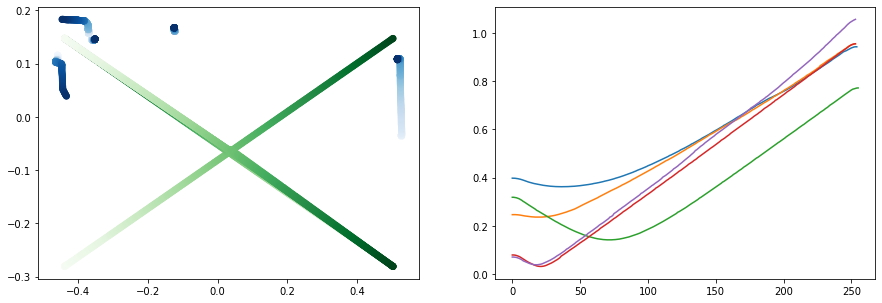

In [174]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for trial_idx, a in parameter_traces.iterrows():
    row = pd.DataFrame(a).T
    row = row.apply(pd.Series.explode)

    ax[0].scatter(row['mouse_x'], row['mouse_y'], c=row['time_vector'], cmap='Blues')
    ax[0].scatter(row['target_x'], row['target_y'], c=row['time_vector'], cmap='Greens')
    ax[1].plot(range(len(row)), row['target_mouse_distance_recalc'])

In [32]:
from matplotlib.gridspec import GridSpec
import ipywidgets as widgets

def plot_approach_params(data, idx=0):
    df = data[idx][0]
    trace = data[idx][1]
    features = data[idx][2]

    fig = plt.figure(figsize=(15,8))
    gs = GridSpec(8, 6, figure=fig)

    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.plot(df['time_vector'], df['target_mouse_distance_recalc']*100)
    ax1.axhline(dist_thresh*100, color='r')
    ax1.axvline(2, color='gray')
    ax1.set_ylabel('Mouse target dist \n (cm)')

    ax2 = fig.add_subplot(gs[2:4, :2])
    ax2.plot(df['time_vector'], df['mouse_speed']*100)
    ax2.axhline(speed_cutoff*100, color='r')
    ax2.set_ylabel('Mouse speed \n (cm/s)')

    ax3 = fig.add_subplot(gs[4:6, :2])
    ax3.plot(df['time_vector'], df['target_delta_heading'])
    # ax3.plot(np.diff(df[idx]['target_delta_heading']))
    ax3.set_ylim([-180, 180])
    ax3.set_ylabel('Target $\Delta$ heading \n (deg)')

    ax4 = fig.add_subplot(gs[6:, :2])
    ax4.plot(df['time_vector'], df['target_delta_head'])
    # ax4.plot(np.diff(df[idx]['target_delta_head']))
    ax4.set_ylim([-180, 180])
    ax4.set_ylabel('Target $\Delta$ head \n (deg)')
    ax4.set_xlabel('Time (s)')

    ax5 = fig.add_subplot(gs[2:6, 2:-1])
    ax5.scatter(trace['target_x'], trace['target_y'], marker='.', c='g', alpha=0.005)
    ax5.scatter(trace['mouse_x'], trace['mouse_y'], marker='.', c='b', alpha=0.01)
    p_tar = ax5.scatter(df['target_x'], df['target_y'], c=df['time_vector'], cmap='RdYlGn')
    p_mouse = ax5.scatter(df['mouse_x'], df['mouse_y'], c=df['time_vector'], cmap='RdYlBu')
    ax5.set_ylim([-0.35, 0.35])
    ax5.set_xlim([-0.65, 0.65])
    ax5.invert_xaxis()
    ax5.yaxis.tick_right()
    ax5.set_title("Color {}, Speed {} cm/s, Size {} cm \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]".format(*features, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

    ax6 = fig.add_subplot(gs[1:4, -1])  
    ax6.axis("off") 
    cba = plt.colorbar(p_tar, ax=ax6)
    cba.set_label('Target') 

    ax7 = fig.add_subplot(gs[4:-1, -1])    
    ax7.axis("off")
    cbb = plt.colorbar(p_mouse, ax=ax7)
    cbb.set_label('Mouse')

    plt.tight_layout()


In [33]:
ds_to_plot = all_valid_encs
widgets.interact(plot_approach_params, data=widgets.fixed(ds_to_plot), idx=(0, len(ds_to_plot) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=141), Output()), _dom_classes=('widget-interac…

<function __main__.plot_approach_params(data, idx=0)>

In [225]:
ds_to_plot = all_encounters
widgets.interact(plot_approach_params, data=widgets.fixed(ds_to_plot), idx=(0, len(ds_to_plot) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=347), Output()), _dom_classes=('widget-interac…

<function __main__.plot_approach_params(data, idx=0)>

In [12]:
def get_mean_sem(df: pd.DataFrame, target_param: str) -> pd.DataFrame:
    grouped = df.groupby(['experiment', 'target_color', target_param])['num_encounters'].sum().reset_index()
    mean = grouped.groupby(['target_color', target_param])['num_encounters'].mean().unstack().T
    sem = grouped.groupby(['target_color', target_param])['num_encounters'].sem().unstack().T

    return grouped, mean, sem

In [13]:
def get_percentage_approach_trials(df: pd.DataFrame, target_param: str) -> pd.DataFrame:
    grouped = df.groupby(['experiment', 'target_color', target_param])['num_encounters']
    percent_approach =  100 * grouped.sum() / grouped.count()
    mean_percent_approach = percent_approach.groupby(['target_color', target_param]).mean().unstack().T
    sem_percent_approach = percent_approach.groupby(['target_color', target_param]).sem().unstack().T
    return percent_approach, mean_percent_approach, sem_percent_approach

In [14]:
def make_percentage_engagement_plot(mean: pd.DataFrame, sem: pd.DataFrame, all_trials: pd.DataFrame, param: str, fig=None):
    fig, ax = plt.subplots(figsize=(10,8))
    width = 0.35
    labels = ['black', 'gray']

    counts = trial_encounters.groupby(['target_color', param])['num_encounters'].sum().unstack().T
    total = trial_encounters.groupby(['target_color', param])['num_encounters'].count().unstack().T

    for i, col in enumerate(mean.columns):
            x_labels = [int(label) for label in mean.index.to_list()]
            x = np.arange(len(x_labels))

            means = mean[col].to_list()
            sems = sem[col].to_list()
            count = counts[col].to_list()
            tot = total[col].to_list()

            rects = ax.bar(x + i*width, means, width, label=labels[i], color=col, edgecolor=(1, 1, 1), yerr=sems, ecolor=(0.5, 0.5, 0.5))
            
            for j, rect in enumerate(rects):
                height = rect.get_height()
                ax.annotate('{}/{}'.format(count[j], tot[j]),
                                xy=(rect.get_x() + rect.get_width() / 2, height + sems[j]),
                                xytext=(0, 15),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')

    ax.set_xlabel(param)
    ax.set_ylabel('% Trials with Approach')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0, 100])
    ax.legend()

    return fig

In [15]:
def make_mean_sem_approach_plot(all_encounters: pd.DataFrame, mean: pd.DataFrame, sem: pd.DataFrame, fig=None):
    
    if fig is None:
        fig = plt.figure(figsize=(10,8))

    trial_encounters.groupby(['target_color', 'speed'])['num_encounters']

    for col in mean.columns:
        x_labels = mean.index.to_list()

        means = mean[col].to_list()
        sems = sem[col].to_list()

        plt.errorbar(x_labels, means, yerr=sems, c=str(col[0]*3), linewidth=5, elinewidth=3)

    plt.ylabel('no. approaches')

    return fig

In [16]:
def rand_jitter(arr):
    stdev = .005 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev  

def plot_scatter_points(data: pd.DataFrame, key:str, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10,8))

    plt.scatter(rand_jitter(data[key]), rand_jitter(data['num_encounters']), s=60, c=[(t[0]*3, t[1]*3, t[2]*3, 1) for t in data['target_color']], linewidths=1, edgecolors='k')

    return fig

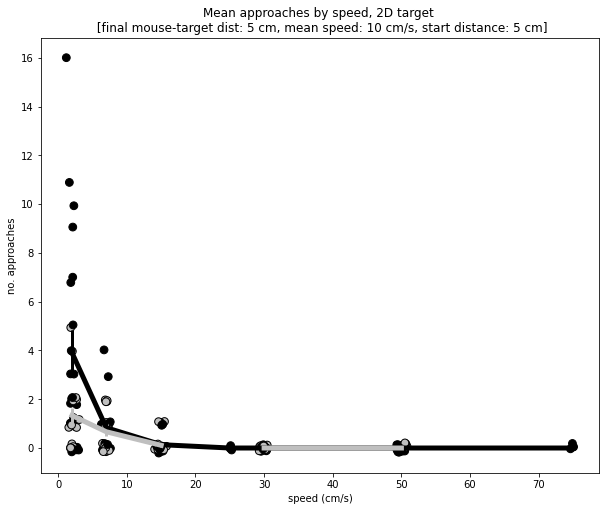

In [28]:
%matplotlib inline
speed_group, speed_mean, speed_sem = get_mean_sem(trial_encounters, 'speed')
fig = plot_scatter_points(speed_group, 'speed')
fig = make_mean_sem_approach_plot(trial_encounters, speed_mean, speed_sem, fig=fig)
plt.xlabel('speed (cm/s)')
plt.title('Mean approaches by speed, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))


save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'speed_encounters', str(int(dist_thresh*100)), str(int(speed_cutoff*100)), str(int(start_distance_cutoff*100))]))
plt.savefig(save_path)

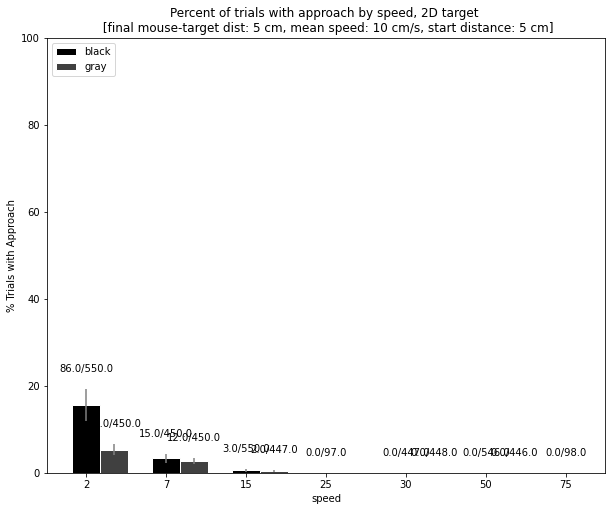

In [29]:
percent_speed_approach, percent_speed_mean, percent_speed_sem = get_percentage_approach_trials(trial_encounters, 'speed')
fig = make_percentage_engagement_plot(percent_speed_mean, percent_speed_sem, trial_encounters, 'speed')
plt.title('Percent of trials with approach by speed, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'speed_percent_engagement', str(int(dist_thresh*100)), str(int(speed_cutoff*100)), str(int(start_distance_cutoff*100))]))
plt.savefig(save_path)

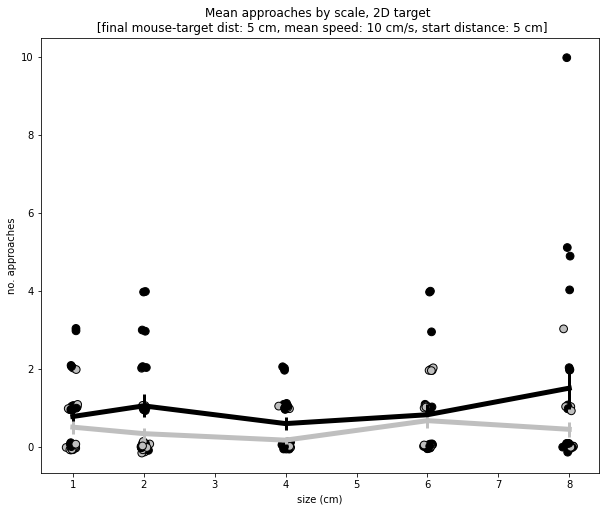

In [30]:
scale_group, scale_mean, scale_sem = get_mean_sem(trial_encounters, 'scale')
fig = plot_scatter_points(scale_group, 'scale')
fig = make_mean_sem_approach_plot(trial_encounters, scale_mean, scale_sem, fig=fig)
plt.xlabel('size (cm)')
plt.title('Mean approaches by scale, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'scale_encounters', str(int(dist_thresh*100)), str(int(speed_cutoff*100)), str(int(start_distance_cutoff*100))]))
plt.savefig(save_path)

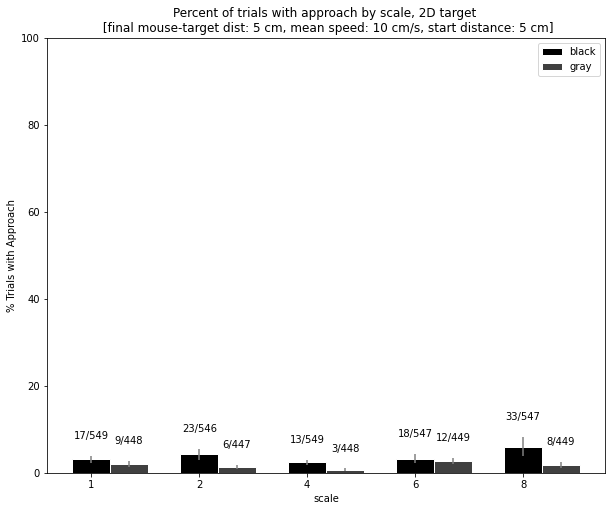

In [31]:
percent_scale_approach, percent_scale_mean, percent_scale_sem = get_percentage_approach_trials(trial_encounters, 'scale')
make_percentage_engagement_plot(percent_scale_mean, percent_scale_sem, trial_encounters, 'scale')
plt.title('Percent of trials with approach by scale, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'scale_percent_engagement', str(int(dist_thresh*100)), str(int(speed_cutoff*100))]))
plt.savefig(save_path)